In [1]:
# import
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [3]:
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

In [4]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [5]:
def get_market_exit_signal(index_data, long_term_ma):
    index_data['Long_Term_MA'] = index_data['Close'].rolling(window=long_term_ma).mean()
    if index_data['Close'].iloc[-1] < index_data['Long_Term_MA'].iloc[-1]:
        return "Exit Market"
    return "Stay"
def check_buy_signal(stock_data, short_window=5, long_window=20, rsi_buy_signal=40):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for buy signal
    buy_signal = (stock_data['Short_MA'].iloc[-1] < stock_data['Long_MA'].iloc[-1]) and \
                 (stock_data['RSI'].iloc[-1] < rsi_buy_signal) and \
                 (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return buy_signal

def check_sell_signal(stock_data, short_window=5, long_window=20, rsi_sell_signal=90):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for sell signal
    sell_signal = (stock_data['Short_MA'].iloc[-1] > stock_data['Long_MA'].iloc[-1]) and \
                  (stock_data['RSI'].iloc[-1] > rsi_sell_signal) and \
                  (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return sell_signal

In [6]:
def decide_trade(stock_data, short_window, long_window, rsi_buy_signal=40, rsi_sell_signal=90):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    buy_signals = (stock_data['Short_MA'] < stock_data['Long_MA']) & (stock_data['RSI'] < rsi_buy_signal) & (stock_data['Volume'] > stock_data['Volume_MA'])
    sell_signals = (stock_data['Short_MA'] > stock_data['Long_MA']) & (stock_data['RSI'] > rsi_sell_signal) & (stock_data['Volume'] > stock_data['Volume_MA'])
    
    return buy_signals, sell_signals

In [7]:
def recommended_pe_ratio(sector):
    pe_ratios = {
        'Technology': (25, 35),
        'Utilities': (10, 20),
        'Consumer Discretionary': (15, 25),
        'Healthcare': (15, 25),
        'Pharmaceuticals': (15, 25),
        'Financial': (10, 15),
        'Energy': (5, 15),
        'Industrials': (15, 25),
        'Materials': (15, 25),
        'Real Estate': (15, 25),
        'Telecommunication': (10, 15),
        'Consumer Staples': (20, 25),
        'Information Technology': (25, 35)
    }
    
    return pe_ratios.get(sector, ('N/A', 'N/A'))  # Default to 'N/A' if the sector is not listed

# Example usage
sector = 'Technology'
print(f"Recommended P/E Ratio for {sector}: {recommended_pe_ratio(sector)}")

Recommended P/E Ratio for Technology: (25, 35)


In [8]:
def backtest_strategy(stock_data, buy_signals, sell_signals, holding_period=30, investment_fraction=0.1):
    initial_balance = 10000  # Example starting balance
    balance = initial_balance
    position = 0
    purchase_price = 0  # To track the purchase price of the stock
    holding_start_date = None  # To track when a stock is bought
    trade_history = []

    for i in range(len(stock_data)):
        current_date = stock_data.index[i]
        current_price = stock_data['Close'][i]

        if buy_signals[i] and balance >= current_price:
            # Buy - use only a fraction of the available balance
            investment_amount = balance * investment_fraction
            shares_to_buy = investment_amount // current_price
            if shares_to_buy > 0:  # Ensuring we have enough balance to buy at least one share
                balance -= shares_to_buy * current_price
                position += shares_to_buy
                purchase_price = current_price
                holding_start_date = current_date
                trade_history.append(('BUY', current_date, current_price, shares_to_buy))

        elif sell_signals[i] and position > 0:
            days_held = (current_date - holding_start_date).days if holding_start_date else 0
            is_profit = current_price > purchase_price

            # Sell if held for at least 30 days or at a loss
            if days_held >= holding_period or not is_profit:
                balance += position * current_price
                trade_history.append(('SELL', current_date, current_price, position))
                position = 0
                holding_start_date = None
                purchase_price = 0

    final_balance = balance + (position * stock_data['Close'].iloc[-1])
    total_return = final_balance - initial_balance
    return_percentage = (total_return / initial_balance) * 100

    return trade_history, total_return, return_percentage

[*********************100%%**********************]  1 of 1 completed

Analyzing BTC-USD...
Buy signals for BTC-USD:
                     Open          High           Low         Close  \
Date                                                                 
2022-05-18  30424.478516  30618.716797  28720.271484  28720.271484   
2022-06-13  26737.578125  26795.589844  22141.257812  22487.388672   
2022-06-14  22487.986328  23018.951172  20950.818359  22206.792969   
2022-06-18  20473.425781  20736.041016  17708.623047  19017.642578   
2022-08-26  21596.085938  21804.908203  20199.482422  20260.019531   
2023-03-09  21720.080078  21802.716797  20210.306641  20363.021484   
2023-03-10  20367.001953  20370.595703  19628.253906  20187.244141   
2023-08-18  26636.078125  26808.195312  25668.921875  26049.556641   
2023-08-22  26130.748047  26135.507812  25520.728516  26031.656250   
2023-08-23  26040.474609  26786.898438  25804.998047  26431.640625   
2023-08-28  26089.615234  26198.578125  25880.599609  26106.150391   
2024-01-22  41553.652344  41651.207031  394

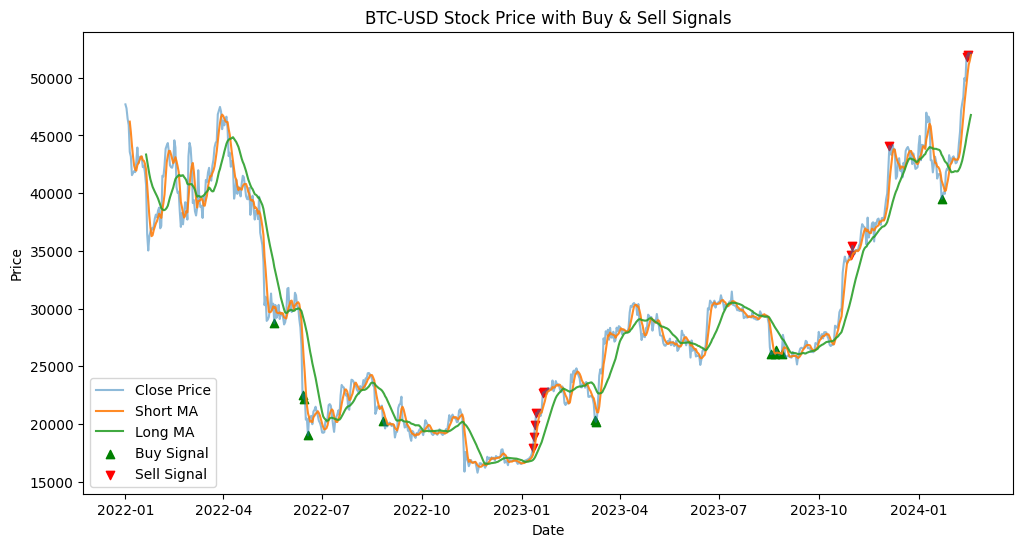

[*********************100%%**********************]  1 of 1 completed

Analyzing ETH-USD...
Buy signals for ETH-USD:
                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-06-13  1443.835449  1448.738037  1181.948242  1204.582764  1204.582764   
2022-06-14  1204.555298  1252.471802  1094.701904  1211.662842  1211.662842   
2022-06-15  1211.365967  1236.627563  1025.684204  1233.206421  1233.206421   
2022-06-20  1127.656250  1159.985352  1066.113159  1127.642456  1127.642456   
2023-08-17  1805.567383  1807.714844  1551.713257  1684.933472  1684.933472   
2023-08-18  1682.038452  1698.124268  1644.930908  1660.945068  1660.945068   
2023-08-22  1667.279297  1668.638672  1596.384033  1633.892578  1633.892578   

                 Volume     Short_MA      Long_MA        RSI     Volume_MA  
Date                                                                        
2022-06-13  45162788786  1526.866211  1756.163019   9.658456  2.405456e+10  
2022-06-14

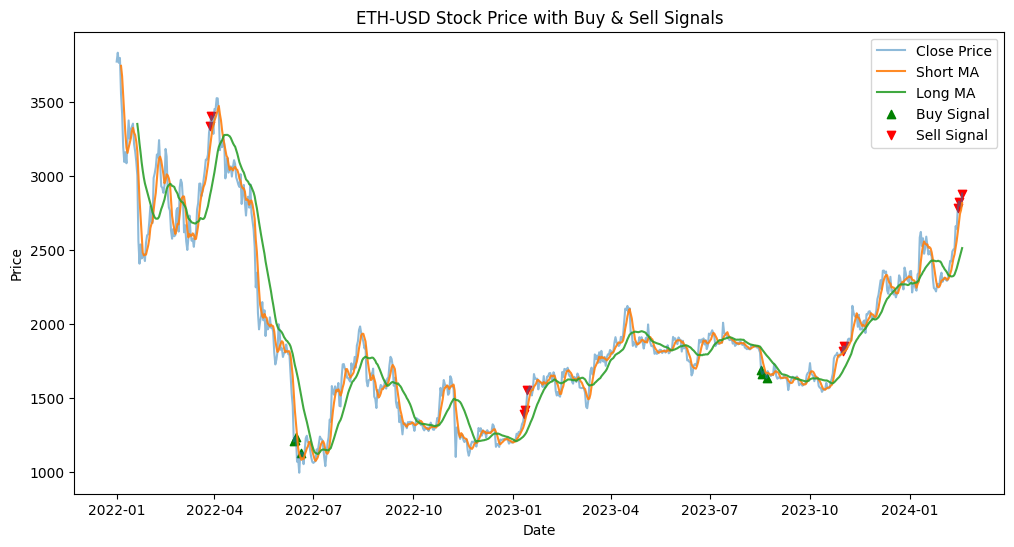

[*********************100%%**********************]  1 of 1 completed

Analyzing NVDA...
Buy signals for NVDA:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-04-21  217.089996  223.919998  200.000000  201.830002  201.830002   
2022-04-22  203.029999  204.860001  195.000000  195.149994  195.149994   
2022-04-25  192.020004  199.449997  190.960007  199.020004  199.020004   
2022-04-26  197.179993  197.880005  186.699997  187.880005  187.880005   
2022-09-02  141.000000  141.710007  135.910004  136.470001  136.470001   
2023-09-21  415.829987  421.000000  409.799988  410.170013  410.170013   
2023-09-22  415.720001  421.149994  412.309998  416.100006  416.100006   
2023-09-25  415.910004  425.359985  411.769989  422.220001  422.220001   

              Volume    Short_MA     Long_MA        RSI   Volume_MA  
Date                                                                 
2022-04-21  65620900  213.808002  245.979000  19.585518  54655240.0  
2022-04-

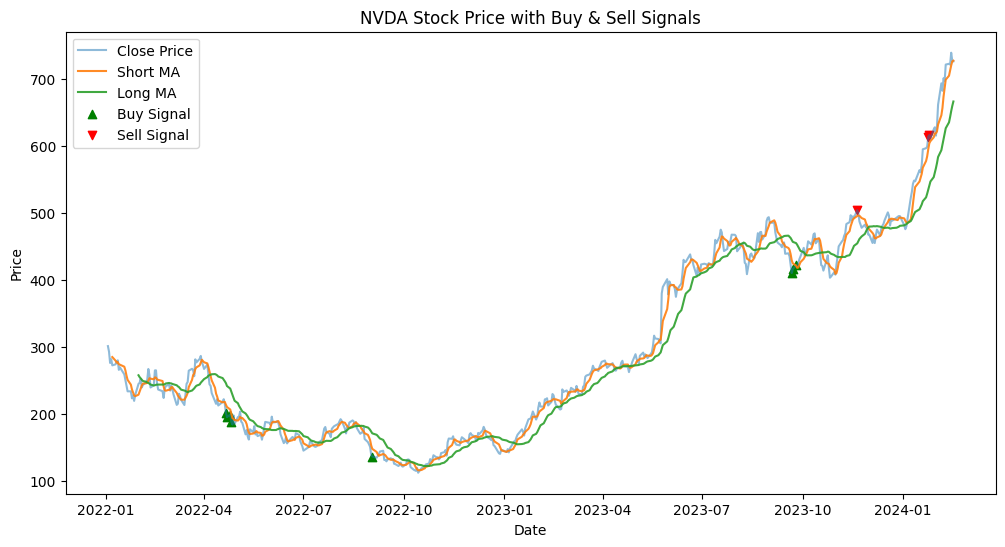

[*********************100%%**********************]  1 of 1 completed

Analyzing SMCI...
Buy signals for SMCI:
              Open       High        Low      Close  Adj Close  Volume  \
Date                                                                    
2022-04-08  34.75  35.619999  34.110001  35.310001  35.310001  262700   

             Short_MA  Long_MA      RSI  Volume_MA  
Date                                                
2022-04-08  36.040001  40.1405  8.97436   196720.0  
Sell signals for SMCI:
                   Open         High         Low        Close    Adj Close  \
Date                                                                        
2022-08-04   57.619999    59.740002   56.990002    59.130001    59.130001   
2022-08-05   58.500000    60.310001   58.000000    59.090000    59.090000   
2022-08-08   59.400002    61.980000   59.320000    61.090000    61.090000   
2023-05-26  209.949997   227.710007  207.009995   219.179993   219.179993   
2023-05-30  228.000000   242.990005  227.669998   234.100006   234.100006   
2023-07-14  298.0

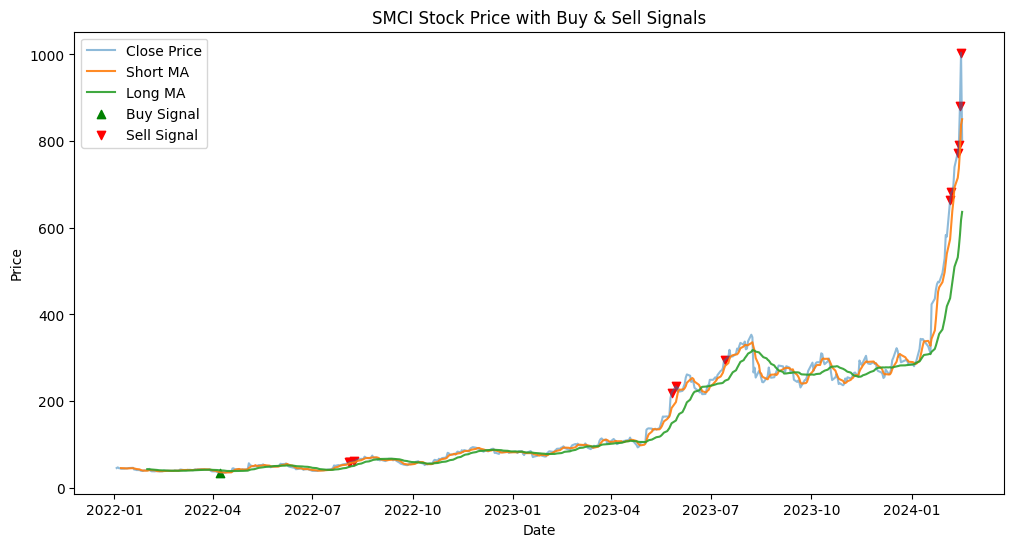

[*********************100%%**********************]  1 of 1 completed

Analyzing AMC...
Buy signals for AMC:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-05-09  136.300003  136.300003  124.300003  125.199997  125.199997   
2022-05-10  131.500000  140.100006  115.000000  118.400002  118.400002   
2022-05-11  115.599998  116.500000   99.099998  103.699997  103.699997   
2022-09-09   88.599998   97.300003   87.800003   97.199997   97.199997   
2022-12-22   41.400002   49.799999   41.099998   49.099998   49.099998   
2023-05-24   50.000000   50.799999   48.000000   48.799999   48.799999   
2023-05-25   49.299999   49.299999   46.200001   47.000000   47.000000   
2023-08-25   13.440000   14.450000   12.400000   12.430000   12.430000   
2023-08-28   11.990000   12.350000   11.050000   11.070000   11.070000   
2023-08-29   11.240000   11.700000   10.720000   10.910000   10.910000   
2023-08-30   11.100000   13.640000   10.730000   12.730000   12.730000   

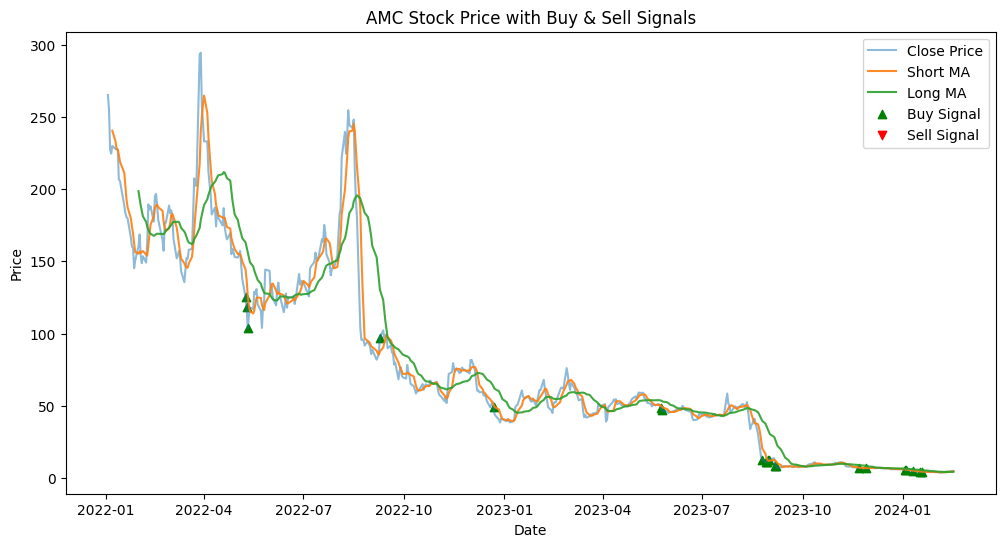

[*********************100%%**********************]  1 of 1 completed

Analyzing META...
Buy signals for META:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-02-23  204.160004  206.940002  198.050003  198.449997  198.449997   
2022-04-27  174.429993  181.210007  169.000000  174.949997  174.949997   
2022-09-29  139.360001  139.839996  135.199997  136.410004  136.410004   

              Volume    Short_MA     Long_MA        RSI   Volume_MA  
Date                                                                 
2022-02-23  44481400  206.188000  245.772001   9.768078  41205440.0  
2022-04-27  71062900  183.014001  210.435501  15.498801  43694460.0  
2022-09-29  38985400  137.839999  150.673500  18.531374  32935620.0  
Sell signals for META:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-11-20  334.890015  341.869995  334.190002  339.970001  339.97

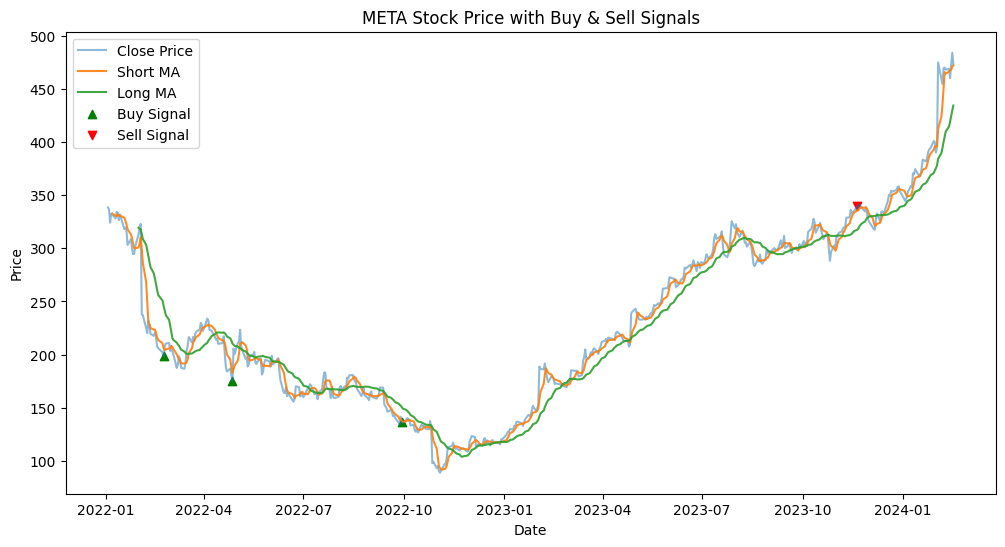

[*********************100%%**********************]  1 of 1 completed

Analyzing SAVE...
Buy signals for SAVE:
                  Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2022-03-08  18.980000  20.080000  18.260000  19.240000  19.240000    6384500   
2022-05-02  21.930000  22.000000  21.059999  21.400000  21.400000    9749500   
2022-05-09  19.340000  19.410000  16.330000  16.809999  16.809999    6399400   
2022-05-12  16.530001  16.639999  15.920000  16.350000  16.350000    5156700   
2022-08-29  23.059999  23.170000  22.750000  22.820000  22.820000    1580400   
2022-08-30  22.900000  22.950001  22.590000  22.700001  22.700001    1134200   
2022-08-31  22.790001  23.000000  22.570000  22.680000  22.680000    1305000   
2022-09-01  22.500000  22.570000  21.950001  22.309999  22.309999    2056900   
2022-09-30  19.780001  20.200001  18.600000  18.820000  18.820000    3532800   
2023-03-06  18.000000  18.450001  16.170000  16.360001  16.360001   13787900   

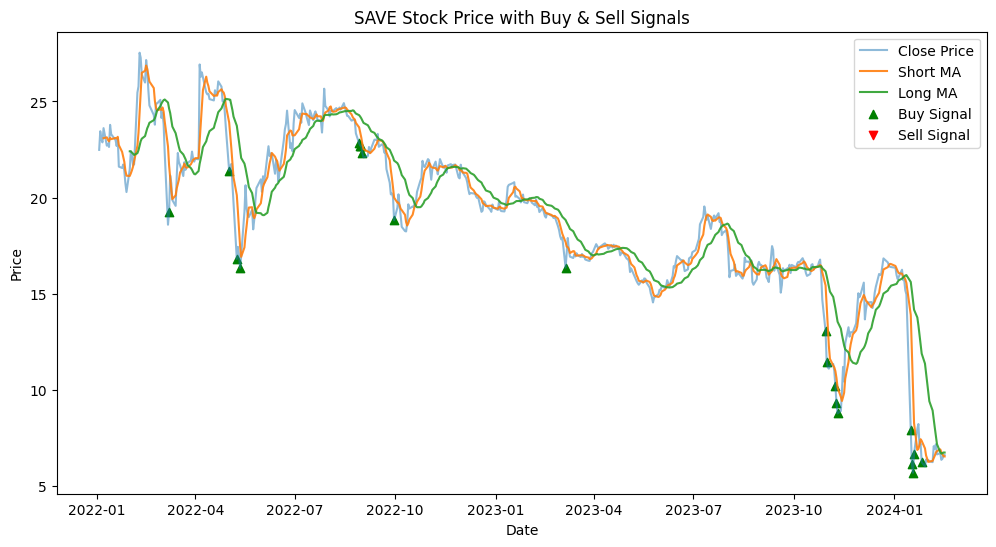

Analyzing LLY...


[*********************100%%**********************]  1 of 1 completed

Buy signals for LLY:
                  Open        High         Low       Close   Adj Close  \
Date                                                                    
2023-09-29  545.48999  546.090027  532.200012  537.130005  537.130005   
2023-10-02  536.01001  540.640015  526.809998  538.289978  538.289978   
2023-10-03  536.00000  537.340027  516.570007  525.190002  525.190002   

             Volume    Short_MA     Long_MA        RSI  Volume_MA  
Date                                                               
2023-09-29  2967100  546.728003  567.307001  12.346910  2140180.0  
2023-10-02  2810100  543.928003  566.366000   9.332022  2364900.0  
2023-10-03  3266100  538.964001  564.716000   7.982607  2645260.0  
Sell signals for LLY:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-03-15  269.869995  276.480011  269.869995  275.459991  275.459991   
2022-03-17  277.010010  285

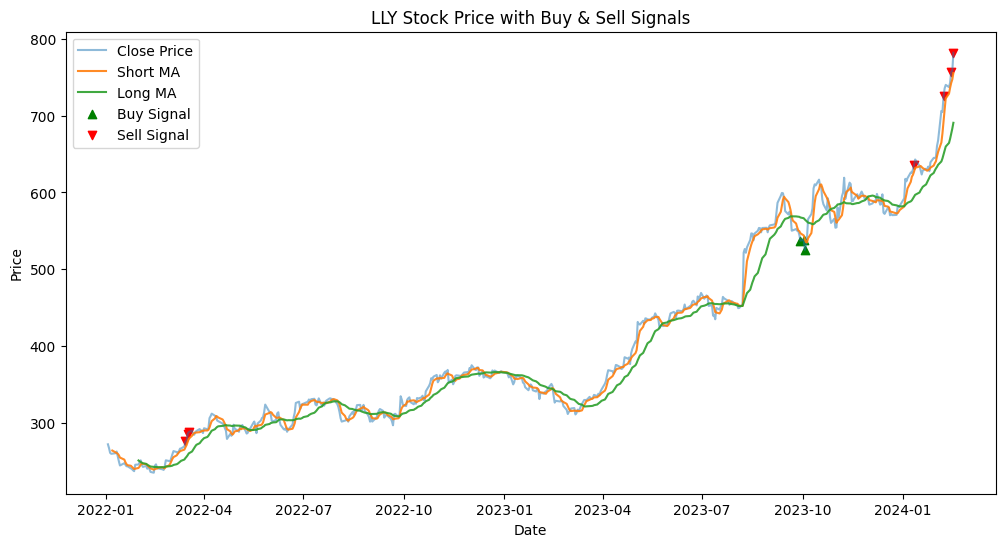

Analyzing BAC...


[*********************100%%**********************]  1 of 1 completed

Buy signals for BAC:
                  Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2022-03-01  43.709999  43.740002  41.930000  42.470001  42.263359   74895600   
2022-03-07  39.930000  40.110001  38.209999  38.340000  38.340000  109779000   
2022-03-08  39.070000  39.660000  38.169998  38.590000  38.590000   76553800   
2022-04-13  38.500000  39.009998  38.360001  38.820000  38.820000   45484200   
2022-04-14  38.490002  38.970001  37.419998  37.570000  37.570000   79032000   
2022-04-18  37.419998  39.310001  37.220001  38.849998  38.849998   80080300   
2022-06-16  31.500000  32.000000  30.860001  31.850000  31.850000   61363400   
2022-06-17  32.029999  32.580002  31.639999  31.920000  31.920000   80470300   
2022-12-06  34.570000  34.680000  32.410000  33.000000  33.000000   84085700   
2022-12-13  33.549999  33.669998  32.570000  32.750000  32.750000   54804800   
2022-12-14  32.799

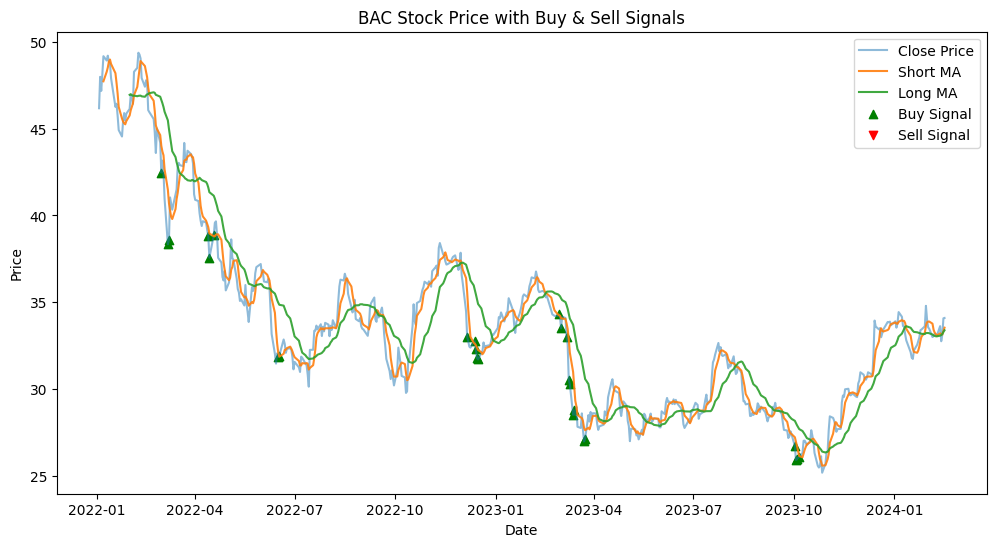

[*********************100%%**********************]  1 of 1 completed


Analyzing SHOP...
Buy signals for SHOP:
                  Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2022-03-08  55.256001  55.499001  51.119999  51.494999  51.494999  52423000   
2022-08-30  32.470001  32.910000  30.530001  31.360001  31.360001  33550300   
2022-09-01  30.940001  31.360001  29.820999  31.270000  31.270000  28553500   
2022-09-02  31.799999  31.990000  29.860001  30.110001  30.110001  31478500   
2022-12-22  35.599998  35.599998  33.389999  34.680000  34.680000  16498400   
2023-08-17  55.689999  55.970001  52.775002  53.220001  53.220001  13873200   
2023-08-18  51.470001  53.250000  51.200001  53.139999  53.139999  12142800   
2023-09-21  55.369999  55.990002  53.680000  53.700001  53.700001  11303200   
2023-09-26  52.900002  53.630001  51.369999  51.509998  51.509998  10456000   

             Short_MA    Long_MA        RSI   Volume_MA  
Date                           

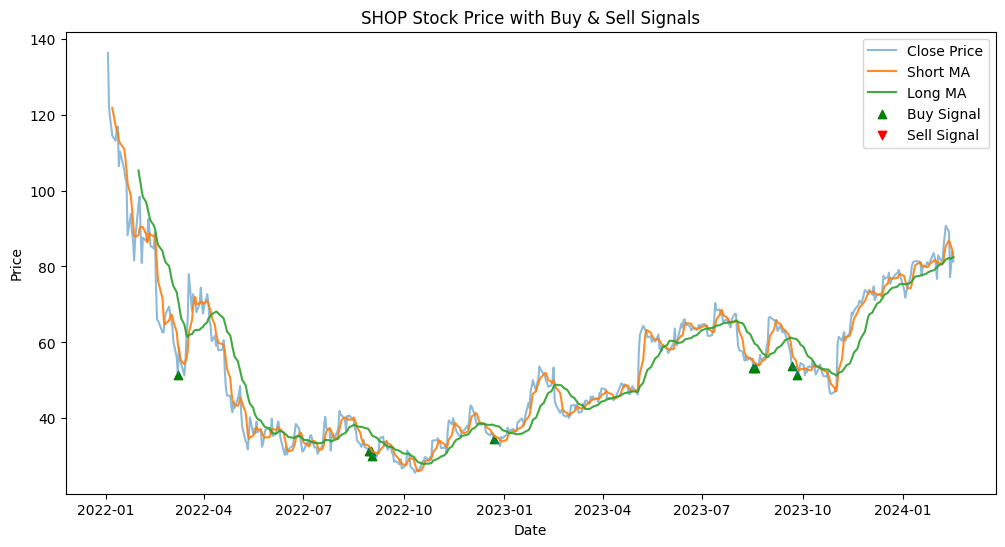

In [38]:

# Define a list of stock tickers
# tickers = ['601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ','603628.SS']

tickers = ['BTC-USD', 'ETH-USD','NVDA','SMCI','AMC','META','SAVE','LLY', 'BAC','SHOP']
start_date = '2022-01-01'
end_date = '2024-02-19'

# Monitor each stock
for ticker in tickers:
    print(f"Analyzing {ticker}...")
    stock = get_stock_data(ticker, start_date, end_date)
    buy, sell = decide_trade(stock, short_window=5, long_window=20, rsi_buy_signal=20, rsi_sell_signal=90)

    # You can store these results in a data structure or database
    print(f"Buy signals for {ticker}:\n", stock[buy])
    print(f"Sell signals for {ticker}:\n", stock[sell])

    # Optional: Plotting
    plt.figure(figsize=(12,6))
    plt.plot(stock['Close'], label='Close Price', alpha=0.5)
    plt.plot(stock['Short_MA'], label='Short MA', alpha=0.9)
    plt.plot(stock['Long_MA'], label='Long MA', alpha=0.9)
    plt.scatter(stock.index[buy], stock['Close'][buy], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(stock.index[sell], stock['Close'][sell], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.title(f'{ticker} Stock Price with Buy & Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()

In [10]:

# # Example usage
# for ticker in tickers:
#   stock = get_stock_data(ticker, start_date, end_date)
#   buy, sell = decide_trade(stock, short_window=5, long_window=20, rsi_buy_signal= 30, rsi_sell_signal=90)
#   trades, total_return, return_percentage = backtest_strategy(stock, buy, sell,30,0.1)
#   print(f"#######################{ticker}##########################")
#   print(f"Trades: {trades}")
#   print(f"Total Return: ${total_return:.2f}")
#   print(f"Return Percentage: {return_percentage:.2f}%")
#   print(f"Hold Return Percentage: {(stock['Close'][len(stock)-1]-stock['Close'][0])/stock['Close'][0]*100:.2f}%")


In [11]:
def get_stock_info_on_date(tickers, date=datetime.today().strftime("%Y-%m-%d"), history_days=600, long_term_ma=200, rsi_buy_signal=40, rsi_sell_signal=90):
    print("Today is " + date)
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=history_days)

    market_index = yf.Ticker("^GSPC")  # S&P 500 Index
    market_data = market_index.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    market_signal = get_market_exit_signal(market_data, long_term_ma)
    print(market_signal)

    data = {'Company Code': [], 'Date': [], 'Daily Price': [], 'Recommendation': [], 'P/E Ratio': [], 'Recommended PE':[], 'Category': [],'Dividend Yield': [], 'Market Cap': [], 'Earnings Growth': [], 'One Year Target': [], 'Analyst Buy': [], 'Analyst Hold': [], 'Analyst Sell': []}
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist_data = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        if hist_data.empty:
            continue  # Skip if no data for the given date range
        
        last_date = hist_data.index[-1].strftime('%Y-%m-%d')  # Last date in the historical data
        daily_price = hist_data['Close'].iloc[-1]  # Last close price
        # Apply buy/sell signal functions (as previously defined)
        buy_signal = check_buy_signal(hist_data,rsi_buy_signal=rsi_buy_signal)
        sell_signal = check_sell_signal(hist_data,rsi_sell_signal=rsi_sell_signal)
        recommendation = 'BUY' if buy_signal else 'SELL' if sell_signal else None

        if recommendation:
            pe_ratio = stock.info.get('trailingPE', 'N/A')
            category = stock.info.get('sector', 'N/A')
            dividend_yield = stock.info.get('dividendYield', 'N/A') * 100 if stock.info.get('dividendYield') is not None else 'N/A'
            market_cap = stock.info.get('marketCap', 'N/A')
            earnings_growth = stock.info.get('earningsGrowth', 'N/A')
            one_year_target = stock.info.get('targetMeanPrice')
            analyst_buy_ratings = stock.info.get('buyRatingCount')
            analyst_hold_ratings = stock.info.get('holdRatingCount')
            analyst_sell_ratings = stock.info.get('sellRatingCount')
            data['Company Code'].append(ticker)
            data['Recommendation'].append(recommendation)
            data['P/E Ratio'].append(pe_ratio)
            data['Category'].append(category)
            data['Dividend Yield'].append(dividend_yield)
            data['Market Cap'].append(market_cap)
            data['Earnings Growth'].append(earnings_growth)
            data['Recommended PE'].append(recommended_pe_ratio(category))
            data['One Year Target'].append(one_year_target)
            data['Analyst Buy'].append(analyst_buy_ratings)
            data['Analyst Hold'].append(analyst_hold_ratings)
            data['Analyst Sell'].append(analyst_sell_ratings)
            data['Date'].append(last_date)
            data['Daily Price'].append(daily_price)

    return pd.DataFrame(data)


In [12]:
def get_sp500_tickers():
    # url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    # sp500_table = pd.read_html(url, header=0)[0]
    # tickers = sp500_table['Symbol'].tolist()
    # print(tickers)
    # return tickers
    return ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EG', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'FLT', 'FMC', 'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GEHC', 'GEN', 'GNRC', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VMC', 'WRB', 'WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WRK', 'WY', 'WHR', 'WMB', 'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']

sp500_tickers = get_sp500_tickers()

In [13]:
def get_nasdaq_tickers():
    # url = 'https://en.wikipedia.org/wiki/NASDAQ-100'
    # tables = pd.read_html(url)  # Scrapes all tables from the Wikipedia page
    # nasdaq_table = tables[4]  # The table with NASDAQ tickers is typically the fourth table on the page
    # nasdaq_tickers = nasdaq_table['Ticker'].tolist()  # Extracts the tickers into a list
    # return nasdaq_tickers
    return ['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']

nasdaq_tickers = get_nasdaq_tickers()
print(nasdaq_tickers)

['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']


# Useless Stock Filter

In [14]:
# # Rules
# def rule_price_above_moving_averages(stock_data):
#     """Price and 50-day MA higher than both 150-day and 200-day MAs."""
#     ma50 = stock_data['Close'].rolling(window=50).mean()
#     ma150 = stock_data['Close'].rolling(window=150).mean()
#     ma200 = stock_data['Close'].rolling(window=200).mean()
#     current_price = stock_data['Close'].iloc[-1]
#     # print(current_price)
#     # print(ma50.iloc[-1])
#     # print(ma150.iloc[-1])
#     # print(ma200.iloc[-1])
#     # print(current_price > ma150.iloc[-1] and current_price > ma200.iloc[-1] and ma50.iloc[-1] > ma150.iloc[-1] and ma50.iloc[-1] > ma200.iloc[-1])
#     return current_price > ma150.iloc[-1] and current_price > ma200.iloc[-1] and ma50.iloc[-1] > ma150.iloc[-1] and ma50.iloc[-1] > ma200.iloc[-1]

# def rule_ma200_uptrend(stock_data, days=30):
#     """200-day MA has been in an uptrend for at least 'days' days."""
#     ma200 = stock_data['Close'].rolling(window=200).mean()
#     # for every ten days, check if it is still the trend
#     for i in range(-1, -days, -10):
#         # print(ma200.iloc[-10*i-1],ma200.iloc[-10*i+9])
#         if ma200.iloc[-10*i-1] >= ma200.iloc[-10*i+9]:
#             return False
#     # print(ma200.iloc[-1] > ma200.iloc[-days])
#     return True 
#     # return ma200.iloc[-1] > ma200.iloc[-days]

# def rule_price_above_52week_low(stock_data, threshold=0.25):
#     """Current price is at least 'threshold' % higher than the 52-week low."""
#     low_52week = stock_data['Close'].rolling(window=252).min().iloc[-1]
#     current_price = stock_data['Close'].iloc[-1]
#     # print(current_price >= low_52week * (1 + threshold))
#     return current_price >= low_52week * (1 + threshold)

# def rule_price_near_52week_high(stock_data, threshold=0.25):
#     """Current price is within 'threshold' % of the 52-week high."""
#     high_52week = stock_data['Close'].rolling(window=252).max().iloc[-1]
#     current_price = stock_data['Close'].iloc[-1]
#     # print(current_price >= high_52week * (1 - threshold))
#     return current_price >= high_52week * (1 - threshold)

In [15]:
# def stock_filter(tickers, rules,date = datetime.today().strftime("%Y-%m-%d")):
#     filtered_stocks = []
#     for ticker in tickers:
#         end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
#         min_history_days = 3*365
#         start_date = end_date - timedelta(days=min_history_days)
#         try:
#             data = yf.download(ticker, start=start_date, end=date, progress=False)
#             if all(rule(data) for rule in rules):
#                 filtered_stocks.append(ticker)
#             # else:
#                 # print(ticker + ' is not recommended to trade')
#         except:
#             continue
#     return filtered_stocks

In [16]:
# filter_rules = [
#     rule_price_above_moving_averages,
#     rule_ma200_uptrend,
#     rule_price_above_52week_low,
#     rule_price_near_52week_high
# ]

# # List of tickers
# # tickers = ['AAPL','AMD','ARKK','ARM','BA', 'BABA','BAC','BILI','BNTX', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DDOG', 'DIS', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'MDB','META', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PDD', 'PLTR', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'TMF', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'WFC','XOM']
# tickers = nasdaq_tickers
# tickers.append(sp500_tickers)
# # tickers=['AAPL',"NVDA","TSLA","MSFT","COIN"]
# # tickers = ['NVDA']
# # Apply the filter
# filtered_stocks = stock_filter(tickers, filter_rules)
# print("Stocks that meet the criteria:", filtered_stocks)

In [17]:
# def test_stock_filter_performance(tickers, rules, start_date, end_date):
#     passed_stocks = stock_filter(tickers, rules, start_date)
#     failed_stocks = set(tickers) - set(passed_stocks)

#     return calculate_average_return(passed_stocks, start_date, end_date), calculate_average_return(failed_stocks, start_date, end_date), passed_stocks, failed_stocks

# def calculate_average_return(stocks, start_date, end_date):
#     returns = []
#     annualized_returns = []
#     start = datetime.strptime(start_date, '%Y-%m-%d')
#     end = datetime.strptime(end_date, '%Y-%m-%d')
#     days_in_period = (end - start).days
#     for ticker in stocks:
#         try:
#             stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
#             if not stock_data.empty:
#                 initial_price = stock_data['Close'].iloc[0]
#                 final_price = stock_data['Close'].iloc[-1]
#                 stock_return = (final_price - initial_price) / initial_price
#                 annualized_return = (1 + stock_return) ** (365.0 / days_in_period) - 1
#                 returns.append(stock_return)
#                 annualized_returns.append(annualized_return)
#         except:
#             continue
#     if returns:
#         return sum(returns) / len(returns), sum(annualized_returns)/len(annualized_returns)
#     else:
#         # need a better solution
#         return 0, 0

# # Example usage
# tickers = sp500_tickers
# start_date = "2023-01-01"
# end_date = '2023-12-01'

# average_return_passed, average_return_failed, passed_stocks, failed_stocks = test_stock_filter_performance(tickers, filter_rules, start_date, end_date)
# print("Average yearly Return of Passed Stocks:", average_return_passed[1], "Number of Passed Stocks: ", len(passed_stocks))
# print(passed_stocks)
# print("Average yearly Return of Failed Stocks:", average_return_failed[1], "Number of Failed Stocks: ", len(failed_stocks))

In [18]:

# def closest_trading_date(data, date):
#     """Find the closest previous trading date in the data for a given date."""
#     if date in data.index:
#         return date
#     # Iterate backwards to find the closest previous date
#     while date not in data.index:
#         date -= pd.Timedelta(days=1)
#     return date

# def test_filter_performance_over_periods(tickers, rules, start_date, end_date):
  
#     # Generate dates at regular intervals between start and end
#     date_range = pd.date_range(start=start_date, end=end_date, freq='M')
#     filtered_stocks = stock_filter(tickers, rules, start_date)
#     unfiltered_stocks = set(tickers) - set(filtered_stocks)

#     # Lists to store results
#     filtered_returns = []
#     unfiltered_returns = []
#     differences = []
#     sp500_returns = []

#     sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']
    
#     for date in date_range:
#         trading_date = closest_trading_date(sp500, date)

#         filtered_avg_return, _ = calculate_average_return(filtered_stocks, start_date, date.strftime('%Y-%m-%d'))
#         unfiltered_avg_return, _ = calculate_average_return(unfiltered_stocks, start_date, date.strftime('%Y-%m-%d'))

#         sp500_return = (sp500.loc[trading_date] - sp500[0]) / sp500[0]

#         filtered_returns.append(filtered_avg_return if filtered_avg_return is not None else 0)
#         unfiltered_returns.append(unfiltered_avg_return if unfiltered_avg_return is not None else 0)
#         differences.append((filtered_avg_return - unfiltered_avg_return) if filtered_avg_return is not None and unfiltered_avg_return is not None else 0)
#         sp500_returns.append(sp500_return)

#     return date_range, filtered_returns, unfiltered_returns, differences, sp500_returns


# start_date = '2022-05-01'
# end_date = '2024-01-01'
# tickers = nasdaq_tickers[30:70]
# date_range, filtered_returns, unfiltered_returns, differences, sp500_returns = test_filter_performance_over_periods(tickers, filter_rules, start_date, end_date)


In [19]:
# plt.figure(figsize=(12, 6))
# plt.plot(date_range, filtered_returns, label='Filtered Stocks')
# plt.plot(date_range, unfiltered_returns, label='Unfiltered Stocks')
# plt.plot(date_range, differences, label='Difference (Filtered - Unfiltered)')
# plt.plot(date_range, sp500_returns, label='S&P 500', linestyle='--')
# plt.xlabel('Date')
# plt.ylabel('Average Return')
# plt.title('Performance Comparison Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()


# Stock Warning

In [20]:
def rule_price_increase(stock_data):
    """Rule 2: 25-50% increase in 1 to 3 weeks."""
    period_returns = stock_data['Close'].pct_change(periods=5).iloc[-1]  # 1-week return
    return 0.25 <= period_returns <= 0.50

def rule_largest_gain(stock_data):
    """Rule 3: Largest single-day gain since rise began."""
    daily_gains = stock_data['Close'].pct_change()
    max_gain = daily_gains.max()
    recent_gain = daily_gains.iloc[-1]
    return recent_gain == max_gain

def rule_accelerating_growth(stock_data):
    """Rule 6: 6-10 days of accelerating growth, with only about 2 days of decline."""
    recent_data = stock_data['Close'].iloc[-10:]
    up_days = recent_data.pct_change() > 0
    return up_days.sum() >= 8

def rule_falling_below_ma(stock_data):
    """Rule 10: Falling below 50-day MA on largest volume."""
    ma50 = stock_data['Close'].rolling(window=50).mean().iloc[-1]
    max_volume = stock_data['Volume'].max()
    recent_volume = stock_data['Volume'].iloc[-1]
    current_price = stock_data['Close'].iloc[-1]
    return current_price < ma50 and recent_volume == max_volume

In [21]:
def stock_warning_system(tickers, date, rules):
    warnings = {}
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=365)
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=date)
        for rule in rules:
            if rule(data):
                warnings.setdefault(ticker, []).append(rule.__name__)
    return warnings

In [22]:
# # Define your rules
# warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]  # Add other rule functions here

# # List of tickers and a specific date
# # tickers = ['AAPL', 'MSFT', 'GOOG']
# tickers = nasdaq_tickers
# date = '2024-01-03'  # Replace with your date

# # Get warnings 
# warnings = stock_warning_system(tickers, date, warning_rules)
# print("Warnings:", warnings)

## Earnings

In [23]:
def upcoming_earnings(tickers, reference_date, within_days=10):
    reference_date = datetime.strptime(reference_date, '%Y-%m-%d')
    days_later = reference_date + timedelta(days=within_days)
    earnings_list = []

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try:
            info = stock.info
            if 'earningsQuarterlyGrowth' not in info: # filter out etfs
                continue
            earnings_data = stock.calendar
            if earnings_data and 'Earnings Date' in earnings_data:
                if len(earnings_data['Earnings Date']) > 0:
                    earnings_date = earnings_data['Earnings Date'][0]
                    earnings_date = pd.to_datetime(earnings_date).to_pydatetime()
                    if reference_date <= earnings_date < days_later:
                        earnings_list.append((ticker, earnings_date))
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")

    # Sort the list by earnings date
    earnings_list.sort(key=lambda x: x[1])
    return earnings_list

# Example usage
# tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN']  # Replace with your list of tickers
# date = '2024-01-24'  # Replace with your reference date

# stocks_with_upcoming_earnings = upcoming_earnings(tickers, date)
# for ticker, earnings_date in stocks_with_upcoming_earnings:
#     print(f"{ticker}: Earnings on {earnings_date}")


# Candlestick Pattern detection function

In [24]:
# def is_bullish_engulfing(data):
#     # Check if the last two days form a bullish engulfing pattern
#     if len(data) >= 2:
#         last_day = data.iloc[-1]
#         prev_day = data.iloc[-2]
#         # print(last_day['Open'], last_day['Close'])
#         return (last_day['Open'] < last_day['Close'] and  # Last day is bullish
#                 prev_day['Open'] > prev_day['Close'] and  # Previous day is bearish
#                 last_day['Open'] < prev_day['Close'] and  # Last day's open is lower than prev day's close
#                 last_day['Close'] > prev_day['Open'])     # Last day's close is higher than prev day's open
#     return False

In [25]:
# def candlestick_alerts(tickers, patterns, date):
#     alerts = {}
#     end_date = pd.to_datetime(date)+pd.Timedelta(days=1)
#     start_date = end_date - pd.Timedelta(days=30)  # Assuming 30 days is enough to detect patterns

#     for ticker in tickers:
#         data = yf.download(ticker, start=start_date, end=end_date)
        
#         for pattern in patterns:
#             if pattern(data):
#                 alerts.setdefault(ticker, []).append(pattern.__name__)

#     return alerts

# # Example usage
# tickers = ['NVDA']
# patterns = [is_bullish_engulfing]  # Add more patterns as needed
# date = '2023-08-14'

# alerts = candlestick_alerts(tickers, patterns, date)
# print(alerts)


# Everyday

In [31]:
def every_day_printer(date = datetime.today().strftime("%Y-%m-%d")):
  # Example usage
  # tickers = get_nasdaq_tickers() # List of tickers
  # tickers = get_sp500_tickers()
  # date = '2024-01-06'
  crypto = ['BTC-USD', 'ETH-USD']
  cn_tickers = ['601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ','603628.SS']
  tickers = ['AAPL','AAL', 'ASML','AMD', 'ABNB','ALK', 'ARKK','ARM', 'AMC','ANET','BABA','BAC','BILI','BNTX','C', 'CDNS', 'CVNA','COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB','META', 'MSFT', 'NKE','NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT','INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'UPS', 'WFC','XOM', 'DHI', 'MMM', 'NFLX']
  tickers = tickers + cn_tickers + crypto
  # tickers = sp500_tickers + nasdaq_tickers

  # File to write the results
  filename = "stock_analysis_results.txt"
  print(tickers)

  # Open the file in append mode
  with open(filename, 'a') as file:
    file.write(f"Analysis Date: {date}\n")
    file.write("Tickers:\n")
    file.write(f"{tickers}\n\n")

    stock_table = get_stock_info_on_date(tickers, date,rsi_buy_signal=20,rsi_sell_signal=90)
    file.write("Stock Table:\n")
    file.write(stock_table.to_string() + "\n\n")  # Convert DataFrame to string before writing
    # Set the display.max_rows option to None
    pd.set_option('display.max_rows', None)
    display(stock_table)

    warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]
    warnings = stock_warning_system(tickers, date, warning_rules)
    print("Warnings:", warnings)
    file.write("Warnings:\n")
    file.write(f"{warnings}\n\n")

    # Get stocks with upcoming earnings and write to file
    file.write("Stocks with Upcoming Earnings:\n")
    stocks_with_upcoming_earnings = upcoming_earnings(tickers, date)
    for ticker, earnings_date in stocks_with_upcoming_earnings:
      print(f"{ticker}: Earnings on {earnings_date}")
      file.write(f"{ticker}: Earnings on {earnings_date}\n")

    file.write(f"\n***************************************************************************************************\n\n")


In [36]:
every_day_printer()

['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2024-02-21
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,BTC-USD,2024-02-20,52284.875000,SELL,N/A,"(N/A, N/A)",N/A,N/A,1006690631680,N/A,None,None,None,None
1,ETH-USD,2024-02-20,3013.503662,SELL,N/A,"(N/A, N/A)",N/A,N/A,350335893504,N/A,None,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'HOOD': ['rule_accelerating_growth'], 'LYFT': ['rule_price_increase']}
CRM: Earnings on 2024-02-27 00:00:00


In [35]:
# import pandas as pd
# import yfinance as yf
# from datetime import datetime

# # Re-initializing after code execution state reset
# # Define the start date and end date
# start_date = "2023-10-01"
# end_date = datetime.today().strftime("%Y-%m-%d")  # Today's date

# # Use a commonly traded stock symbol to get trade dates (assuming NYSE calendar for this example)
# ticker = "^GSPC"  # S&P 500 Index

# # Download historical data for the ticker
# data = yf.download(ticker, start=start_date, end=end_date)

# # Extract the dates where trades occurred
# trade_dates = data.index.strftime("%Y-%m-%d").tolist()

# trade_dates
# for trade_date in trade_dates:
#   every_day_printer(trade_date)

[*********************100%%**********************]  1 of 1 completed

['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-02
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,AAL,2023-10-02,12.750000,BUY,12.22314,"(15, 25)",Industrials,N/A,9676697600,-0.974,17.27,None,None,None
1,ARKK,2023-10-02,39.040001,BUY,N/A,"(N/A, N/A)",N/A,N/A,N/A,N/A,NaN,None,None,None
2,BAC,2023-10-02,26.488585,BUY,10.941559,"(N/A, N/A)",Financial Services,2.83,266076995584,-0.588,38.03,None,None,None
3,LLY,2023-10-02,536.357117,BUY,135.12862,"(15, 25)",Healthcare,0.69,708097540096,0.131,760.37,None,None,None
4,NEE,2023-10-02,51.729061,BUY,15.861111,"(10, 20)",Utilities,3.61,117193744384,-0.234,71.87,None,None,None
5,BA,2023-10-02,187.830002,BUY,N/A,"(15, 25)",Industrials,N/A,122984914944,N/A,258.23,None,None,None
6,UAL,2023-10-02,41.619999,BUY,5.583016,"(15, 25)",Industrials,N/A,14449060864,-0.291,63.84,None,None,None
7,MMM,2023-10-02,87.371025,BUY,N/A,"(15, 25)",Industrials,6.58,50688118784,0.744,104.50,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'NKE': ['rule_falling_below_ma'], 'ETH-USD': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-03
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,ARKK,2023-10-03,37.970001,BUY,N/A,"(N/A, N/A)",N/A,N/A,N/A,N/A,NaN,None,None,None
1,BAC,2023-10-03,25.704840,BUY,10.941559,"(N/A, N/A)",Financial Services,2.83,266076995584,-0.588,38.03,None,None,None
2,CRM,2023-10-03,199.830002,BUY,107.81368,"(25, 35)",Technology,N/A,274476384256,4.952,293.99,None,None,None
3,LLY,2023-10-03,523.304138,BUY,135.12862,"(15, 25)",Healthcare,0.69,708097540096,0.131,760.37,None,None,None
4,NEE,2023-10-03,52.353973,BUY,15.861111,"(10, 20)",Utilities,3.61,117193744384,-0.234,71.87,None,None,None
5,SBUX,2023-10-03,88.458778,BUY,25.406416,"(N/A, N/A)",Consumer Cyclical,2.44,107583545344,0.216,107.15,None,None,None
6,BA,2023-10-03,188.919998,BUY,N/A,"(15, 25)",Industrials,N/A,122984914944,N/A,258.23,None,None,None
7,TMF,2023-10-03,42.358738,BUY,N/A,"(N/A, N/A)",N/A,N/A,N/A,N/A,NaN,None,None,None
8,UAL,2023-10-03,40.529999,BUY,5.583016,"(15, 25)",Industrials,N/A,14449060864,-0.291,63.84,None,None,None
9,UHAL,2023-10-03,52.490002,BUY,20.503086,"(15, 25)",Industrials,0.28,12791229440,-0.501,64.10,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'NEE': ['rule_falling_below_ma']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-04
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,BAC,2023-10-04,25.734604,BUY,10.941559,"(N/A, N/A)",Financial Services,2.83,266076995584,-0.588,38.03,None,None,None
1,BA,2023-10-04,186.729996,BUY,N/A,"(15, 25)",Industrials,N/A,122984914944,N/A,258.23,None,None,None
2,MMM,2023-10-04,85.240501,BUY,N/A,"(15, 25)",Industrials,6.58,50688118784,0.744,104.50,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-05
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,ALK,2023-10-05,35.680000,BUY,21.409836,"(15, 25)",Industrials,N/A,4940206080,N/A,51.10,None,None,None
1,CVNA,2023-10-05,35.740002,BUY,N/A,"(N/A, N/A)",Consumer Cyclical,N/A,8773440512,N/A,38.89,None,None,None
2,KO,2023-10-05,51.966213,BUY,24.793522,"(N/A, N/A)",Consumer Defensive,3.2,264095039488,-0.005,66.27,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'SMCI': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-06
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,ALK,2023-10-06,35.070000,BUY,21.409836,"(15, 25)",Industrials,N/A,4940206080,N/A,51.10,None,None,None
1,BAC,2023-10-06,25.863573,BUY,10.941559,"(N/A, N/A)",Financial Services,2.83,266076995584,-0.588,38.03,None,None,None
2,KO,2023-10-06,52.720211,BUY,24.793522,"(N/A, N/A)",Consumer Defensive,3.2,264095039488,-0.005,66.27,None,None,None
3,TMF,2023-10-06,41.767685,BUY,N/A,"(N/A, N/A)",N/A,N/A,N/A,N/A,NaN,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'SMCI': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-09
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,ALK,2023-10-09,34.450001,BUY,21.409836,"(15, 25)",Industrials,N/A,4940206080,N/A,51.10,None,None,None
1,UAL,2023-10-09,39.779999,BUY,5.583016,"(15, 25)",Industrials,N/A,14449060864,-0.291,63.84,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'SMCI': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-10
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'DUOL': ['rule_accelerating_growth'], 'MDB': ['rule_accelerating_growth'], 'MSFT': ['rule_accelerating_growth'], 'PDD': ['rule_accelerating_growth'], 'SMCI': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-11
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'AMC': ['rule_price_increase'], 'DUOL': ['rule_accelerating_growth'], 'MDB': ['rule_accelerating_growth'], 'PDD': ['rule_accelerating_growth'], 'SMCI': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-12
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'MDB': ['rule_accelerating_growth'], 'PDD': ['rule_accelerating_growth'], 'XOM': ['rule_falling_below_ma']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-13
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'AMC': ['rule_price_increase'], 'LLY': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-16
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-17
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'LLY': ['rule_accelerating_growth'], 'WFC': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-18
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'WFC': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-19
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'NKE': ['rule_accelerating_growth'], 'UAL': ['rule_falling_below_ma'], '600733.SS': ['rule_price_increase']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-20
Exit Market


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'TMF': ['rule_falling_below_ma'], 'NFLX': ['rule_largest_gain'], '600733.SS': ['rule_price_increase']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-23
Exit Market


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,600221.SS,2023-10-23,1.34,BUY,29.0,"(15, 25)",Industrials,N/A,62623764480,N/A,None,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'600733.SS': ['rule_price_increase']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-24
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-25
Exit Market


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'NEE': ['rule_largest_gain'], '300169.SZ': ['rule_price_increase']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-26
Exit Market


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,CVNA,2023-10-26,29.100000,BUY,N/A,"(N/A, N/A)",Consumer Cyclical,N/A,8773440512,N/A,38.89,None,None,None
1,DAL,2023-10-26,31.600000,BUY,5.684797,"(15, 25)",Industrials,0.98,26221887488,1.436,54.53,None,None,None
2,UPS,2023-10-26,138.210007,BUY,19.008974,"(15, 25)",Industrials,4.4,126422859776,-0.529,159.58,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'300169.SZ': ['rule_price_increase']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-27
Exit Market


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,CVNA,2023-10-27,28.580000,BUY,N/A,"(N/A, N/A)",Consumer Cyclical,N/A,8773440512,N/A,38.89,None,None,None
1,DAL,2023-10-27,30.650000,BUY,5.684797,"(15, 25)",Industrials,0.98,26221887488,1.436,54.53,None,None,None
2,UPS,2023-10-27,134.830002,BUY,19.008974,"(15, 25)",Industrials,4.4,126422859776,-0.529,159.58,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'ETH-USD': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-30
Exit Market


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,DAL,2023-10-30,31.230000,BUY,5.684797,"(15, 25)",Industrials,0.98,26221887488,1.436,54.53,None,None,None
1,SAVE,2023-10-30,13.060000,BUY,N/A,"(15, 25)",Industrials,N/A,712701824,N/A,7.50,None,None,None
2,TSLA,2023-10-30,197.360001,BUY,45.29535,"(N/A, N/A)",Consumer Cyclical,N/A,620301582336,1.115,207.75,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'INTC': ['rule_largest_gain']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-10-31
Exit Market


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,SAVE,2023-10-31,11.480000,BUY,N/A,"(15, 25)",Industrials,N/A,712701824,N/A,7.50,None,None,None
1,TSLA,2023-10-31,200.839996,BUY,45.29535,"(N/A, N/A)",Consumer Cyclical,N/A,620301582336,1.115,207.75,None,None,None
2,BTC-USD,2023-10-31,34667.781250,SELL,N/A,"(N/A, N/A)",N/A,N/A,1008548904960,N/A,NaN,None,None,None
3,ETH-USD,2023-10-31,1816.458984,SELL,N/A,"(N/A, N/A)",N/A,N/A,351210438656,N/A,NaN,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-01
Exit Market


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,CVNA,2023-11-01,25.990000,BUY,N/A,"(N/A, N/A)",Consumer Cyclical,N/A,8773440512,N/A,38.89,None,None,None
1,BTC-USD,2023-11-01,35437.253906,SELL,N/A,"(N/A, N/A)",N/A,N/A,1008548904960,N/A,NaN,None,None,None
2,ETH-USD,2023-11-01,1847.089722,SELL,N/A,"(N/A, N/A)",N/A,N/A,351210438656,N/A,NaN,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-02
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-03
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'DASH': ['rule_largest_gain'], 'MSFT': ['rule_accelerating_growth'], 'SHOP': ['rule_price_increase'], 'SBUX': ['rule_largest_gain'], 'BA': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-06
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'DASH': ['rule_price_increase'], 'MSFT': ['rule_accelerating_growth'], 'PLTR': ['rule_price_increase'], 'SHOP': ['rule_price_increase'], 'BA': ['rule_accelerating_growth'], 'TMF': ['rule_falling_below_ma']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-07
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'MSFT': ['rule_accelerating_growth'], 'PLTR': ['rule_price_increase'], 'SHOP': ['rule_price_increase'], 'ETH-USD': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-08
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,SAVE,2023-11-08,10.2,BUY,N/A,"(15, 25)",Industrials,N/A,712701824,N/A,7.5,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'CVNA': ['rule_price_increase'], 'DDOG': ['rule_price_increase', 'rule_largest_gain'], 'MSFT': ['rule_accelerating_growth'], 'PLTR': ['rule_price_increase'], 'SHOP': ['rule_price_increase'], 'UBER': ['rule_accelerating_growth'], 'DHI': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-09
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,SAVE,2023-11-09,9.31,BUY,N/A,"(15, 25)",Industrials,N/A,712701824,N/A,7.5,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'AAPL': ['rule_accelerating_growth'], 'CDNS': ['rule_accelerating_growth'], 'CVNA': ['rule_price_increase'], 'MSFT': ['rule_accelerating_growth'], 'NVDA': ['rule_accelerating_growth'], 'ORCL': ['rule_accelerating_growth'], 'RBLX': ['rule_accelerating_growth'], 'SHOP': ['rule_price_increase'], 'UBER': ['rule_accelerating_growth'], 'DHI': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-

,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,SAVE,2023-11-10,8.78,BUY,N/A,"(15, 25)",Industrials,N/A,712701824,N/A,7.5,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'CDNS': ['rule_accelerating_growth'], 'COIN': ['rule_accelerating_growth'], 'DDOG': ['rule_price_increase'], 'DIS': ['rule_largest_gain'], 'DUOL': ['rule_price_increase'], 'MSFT': ['rule_accelerating_growth'], 'NVDA': ['rule_accelerating_growth'], 'SNAP': ['rule_accelerating_growth'], 'UBER': ['rule_accelerating_growth'], 'ETH-USD': ['rule_largest_gain']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today

,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'CDNS': ['rule_accelerating_growth'], 'COIN': ['rule_accelerating_growth'], 'DDOG': ['rule_price_increase'], 'DUOL': ['rule_price_increase', 'rule_accelerating_growth'], 'MSFT': ['rule_accelerating_growth'], 'NVDA': ['rule_accelerating_growth'], 'SNAP': ['rule_accelerating_growth'], 'UBER': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-14
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,CDNS,2023-11-14,272.619995,SELL,76.314964,"(25, 35)",Technology,N/A,79156215808,0.351,322.34,None,None,None
1,SNAP,2023-11-14,12.150000,SELL,N/A,"(N/A, N/A)",Communication Services,N/A,17727766528,N/A,14.12,None,None,None
2,BA,2023-11-14,207.470001,SELL,N/A,"(15, 25)",Industrials,N/A,122984914944,N/A,258.23,None,None,None
3,DHI,2023-11-14,128.899994,SELL,10.373919,"(N/A, N/A)",Consumer Cyclical,0.83,47778328576,0.022,159.83,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'CDNS': ['rule_accelerating_growth'], 'DDOG': ['rule_price_increase'], 'DUOL': ['rule_price_increase', 'rule_accelerating_growth'], 'META': ['rule_accelerating_growth'], 'NVDA': ['rule_accelerating_growth'], 'UBER': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-15
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'BAC': ['rule_largest_gain'], 'CDNS': ['rule_accelerating_growth'], 'DUOL': ['rule_price_increase', 'rule_accelerating_growth'], 'KRE': ['rule_largest_gain'], 'META': ['rule_accelerating_growth'], 'NVDA': ['rule_accelerating_growth'], 'SNAP': ['rule_accelerating_growth'], 'UBER': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-16
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,SNAP,2023-11-16,12.07,SELL,N/A,"(N/A, N/A)",Communication Services,N/A,17727766528,N/A,14.12,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'CDNS': ['rule_accelerating_growth'], 'META': ['rule_accelerating_growth'], 'NVDA': ['rule_accelerating_growth'], 'PDD': ['rule_accelerating_growth'], 'SAVE': ['rule_largest_gain'], 'SNAP': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-17
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'CDNS': ['rule_accelerating_growth'], 'META': ['rule_accelerating_growth'], 'NVDA': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-20
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,COIN,2023-11-20,106.099998,SELL,438.945950,"(N/A, N/A)",Financial Services,N/A,39347884032,N/A,0.40,None,None,None
1,META,2023-11-20,339.970001,SELL,31.432505,"(N/A, N/A)",Communication Services,0.43,1193200320512,2.002,503.80,None,None,None
2,NVDA,2023-11-20,504.089996,SELL,89.248670,"(25, 35)",Technology,0.02,1666558459904,12.741,729.74,None,None,None
3,UBER,2023-11-20,54.750000,SELL,87.862070,"(25, 35)",Technology,N/A,158727667712,1.269,84.90,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'CDNS': ['rule_accelerating_growth'], 'DUOL': ['rule_accelerating_growth'], 'META': ['rule_accelerating_growth'], 'SAVE': ['rule_price_increase', 'rule_largest_gain', 'rule_falling_below_ma']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-21
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,COIN,2023-11-21,105.489998,SELL,438.94595,"(N/A, N/A)",Financial Services,N/A,39347884032,N/A,0.4,None,None,None
1,UBER,2023-11-21,54.849998,SELL,87.86207,"(25, 35)",Technology,N/A,158727667712,1.269,84.9,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'ARM': ['rule_largest_gain'], 'CDNS': ['rule_accelerating_growth'], 'DUOL': ['rule_accelerating_growth'], 'META': ['rule_accelerating_growth'], 'SAVE': ['rule_price_increase'], 'SPOT': ['rule_accelerating_growth'], 'BA': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-22
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,AMC,2023-11-22,6.99,BUY,N/A,"(N/A, N/A)",Communication Services,N/A,1133158912,N/A,6.22,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'CDNS': ['rule_accelerating_growth'], 'DDOG': ['rule_accelerating_growth'], 'ISRG': ['rule_accelerating_growth'], 'SAVE': ['rule_price_increase'], 'BA': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth'], 'UBER': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-24
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,COIN,2023-11-24,115.540001,SELL,438.94595,"(N/A, N/A)",Financial Services,N/A,39347884032,N/A,0.4,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'DDOG': ['rule_accelerating_growth'], 'ISRG': ['rule_accelerating_growth'], 'KO': ['rule_accelerating_growth'], 'SHOP': ['rule_accelerating_growth'], 'BA': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth'], 'UBER': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-27
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,COIN,2023-11-27,119.769997,SELL,438.94595,"(N/A, N/A)",Financial Services,N/A,39347884032,N/A,0.40,None,None,None
1,DDOG,2023-11-27,111.919998,SELL,898.85710,"(25, 35)",Technology,N/A,41345232896,N/A,147.76,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'DDOG': ['rule_accelerating_growth'], 'ISRG': ['rule_accelerating_growth'], 'KO': ['rule_accelerating_growth'], 'BA': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth'], 'UPS': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-28
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,AMC,2023-11-28,6.700000,BUY,N/A,"(N/A, N/A)",Communication Services,N/A,1133158912,N/A,6.22,None,None,None
1,COIN,2023-11-28,128.270004,SELL,438.94595,"(N/A, N/A)",Financial Services,N/A,39347884032,N/A,0.40,None,None,None
2,BA,2023-11-28,222.369995,SELL,N/A,"(15, 25)",Industrials,N/A,122984914944,N/A,258.23,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'ISRG': ['rule_accelerating_growth'], 'INTC': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-29
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,COIN,2023-11-29,127.820000,SELL,438.94595,"(N/A, N/A)",Financial Services,N/A,39347884032,N/A,0.40,None,None,None
1,DDOG,2023-11-29,116.650002,SELL,898.8571,"(25, 35)",Technology,N/A,41345232896,N/A,147.76,None,None,None
2,BA,2023-11-29,224.429993,SELL,N/A,"(15, 25)",Industrials,N/A,122984914944,N/A,258.23,None,None,None
3,UBER,2023-11-29,56.400002,SELL,87.86207,"(25, 35)",Technology,N/A,158727667712,1.269,84.90,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'LYFT': ['rule_largest_gain'], 'INTC': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-11-30
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,CRM,2023-11-30,251.899994,SELL,107.81368,"(25, 35)",Technology,N/A,274476384256,4.952,293.99,None,None,None
1,DDOG,2023-11-30,116.570000,SELL,898.8571,"(25, 35)",Technology,N/A,41345232896,N/A,147.76,None,None,None
2,JPM,2023-11-30,156.080002,SELL,11.146026,"(N/A, N/A)",Financial Services,2.34,521058910208,-0.15,191.33,None,None,None
3,BA,2023-11-30,231.630005,SELL,N/A,"(15, 25)",Industrials,N/A,122984914944,N/A,258.23,None,None,None
4,UBER,2023-11-30,56.380001,SELL,87.86207,"(25, 35)",Technology,N/A,158727667712,1.269,84.90,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'INTC': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth'], 'UBER': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-12-01
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,CRM,2023-12-01,260.000000,SELL,107.81368,"(25, 35)",Technology,N/A,274476384256,4.952,293.99,None,None,None
1,BA,2023-12-01,233.869995,SELL,N/A,"(15, 25)",Industrials,N/A,122984914944,N/A,258.23,None,None,None
2,UBER,2023-12-01,57.349998,SELL,87.86207,"(25, 35)",Technology,N/A,158727667712,1.269,84.90,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'PDD': ['rule_price_increase'], 'BA': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-12-04
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,COIN,2023-12-04,141.089996,SELL,438.945950,"(N/A, N/A)",Financial Services,N/A,39347884032,N/A,0.40,None,None,None
1,JPM,2023-12-04,157.990005,SELL,11.146026,"(N/A, N/A)",Financial Services,2.34,521058910208,-0.15,191.33,None,None,None
2,UBER,2023-12-04,58.630001,SELL,87.862070,"(25, 35)",Technology,N/A,158727667712,1.269,84.90,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'LYFT': ['rule_price_increase', 'rule_largest_gain'], 'PFE': ['rule_falling_below_ma'], 'SNAP': ['rule_accelerating_growth'], 'BA': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-12-05
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,SBUX,2023-12-05,95.540001,BUY,25.406416,"(N/A, N/A)",Consumer Cyclical,2.4,107583545344,0.216,107.15,None,None,None
1,BTC-USD,2023-12-05,44080.648438,SELL,N/A,"(N/A, N/A)",N/A,N/A,1008146644992,N/A,NaN,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'ALK': ['rule_falling_below_ma'], 'CVNA': ['rule_price_increase'], 'SNAP': ['rule_accelerating_growth'], 'BA': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth'], 'UHAL': ['rule_accelerating_growth'], 'WFC': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-12-06
Stay


,Company Code,Date,Daily Price,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,BABA,2023-12-06,71.489998,BUY,14.048327,"(N/A, N/A)",Consumer Cyclical,1.32,188950003712,-0.684,110.5,None,None,None
1,OXY,2023-12-06,56.480000,BUY,15.505128,"(5, 15)",Energy,1.46,53183307776,-0.379,66.0,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'HOOD': ['rule_largest_gain', 'rule_accelerating_growth'], 'SAVE': ['rule_falling_below_ma'], 'SNAP': ['rule_accelerating_growth'], 'TRV': ['rule_accelerating_growth'], 'WFC': ['rule_accelerating_growth']}
['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', 'BTC-USD', 'ETH-USD']
Today is 2023-12-07
Stay


KeyboardInterrupt: 